### Импортируем библиотеки

In [6]:
import requests
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

### Зададим переменные для парсинга курса валют.
#### Выберем для выполнения задания следующие валюты:
    - Биткоин ('BTC')
    - Евро ('EUR')
    - Британскй фунт стерлингов ('GBR')
    - Японская йена ('JPY')
    - Китайсий юань ('CNY')

In [7]:
start_date = '2023-06-01'
end_date = '2023-06-30'
bases = ['BTC', 'EUR', 'GBR', 'JPY', 'CNY']
symbols = 'RUB'
format = 'CSV'

### Создадим цикл и пройдемся по списку валют, значение курса которых нам необходимо спарсить. Сохраним результат парсинга по каждой валюте в формате *.csv.
#### Полученные файлы:
    - exchange_june2023_BTC.csv
    - exchange_june2023_EUR.csv
    - exchange_june2023_GBR.csv
    - exchange_june2023_JPY.csv
    - exchange_june2023_CNY.csv

In [8]:
for base in bases:
    response = requests.get('https://api.exchangerate.host/timeseries?',
                                params={'base': base,
                                        'start_date': start_date,
                                        'end_date': end_date,
                                        'symbols': symbols,
                                        'format': format
                                })

    with open(f'./csv_files/exchange_june2023_{base}.csv', 'wb') as f:
        f.write(response.content)

### Напишем цикл, в котором прочитаем каждый полученный файл по каждой валюте *.csv средствами Pandas для замены разделителя десятичных знаков с "," на ".", чтобы данные таблицы корректно загрузились в базу данных. Выведем на печать первые 5 строк таблицы по каждой валюте.

In [11]:
for base in bases:
    df = pd.read_csv(f'./csv_files/exchange_june2023_{base}.csv', decimal=',', index_col=False)
    df = pd.DataFrame(df)
    df.to_csv(f'./csv_files/exchange_june2023_{base}.csv', index=False)
    print()
    print(f'Первые 5 строк значений валюты {base}:')
    print(df[:5])



Первые 5 строк значений валюты BTC:
         date code            rate base  start_date    end_date
0  2023-06-01  RUB      2180140.15  BTC  2023-06-01  2023-06-30
1  2023-06-02  RUB  2219636.307692  BTC  2023-06-01  2023-06-30
2  2023-06-03  RUB       2164137.0  BTC  2023-06-01  2023-06-30
3  2023-06-04  RUB  2216853.948718  BTC  2023-06-01  2023-06-30
4  2023-06-05  RUB  2060826.642857  BTC  2023-06-01  2023-06-30

Первые 5 строк значений валюты EUR:
         date code       rate base  start_date    end_date
0  2023-06-01  RUB   87.17187  EUR  2023-06-01  2023-06-30
1  2023-06-02  RUB   86.51849  EUR  2023-06-01  2023-06-30
2  2023-06-03  RUB  86.481161  EUR  2023-06-01  2023-06-30
3  2023-06-04  RUB  86.427659  EUR  2023-06-01  2023-06-30
4  2023-06-05  RUB  86.496161  EUR  2023-06-01  2023-06-30

Первые 5 строк значений валюты GBR:
         date code       rate base  start_date    end_date
0  2023-06-01  RUB  87.205606  GBR  2023-06-01  2023-06-30
1  2023-06-02  RUB  86.565816  GB

### Создадим подключение к базе Postgres, которую мы развернули в docker-compose:

In [58]:
conn = psycopg2.connect(database='exchange',
                        user='postgres',
                        password='password',
                        host='exchange',
                        port=5432)
cur = conn.cursor()

### C помощью цикла FOREACH и динамического SQL в PostgreSQL создадим сразу несколько таблиц:
    - rate_june2023_btc;
    - rate_june2023_eur;
    - rate_june2023_gbr;
    - rate_june2023_jpy;
    - rate_june2023_cny.

In [54]:
cur.execute("""
DO $$
DECLARE
  value TEXT;
  values_arr TEXT[] := ARRAY['rate_june2023_btc', 'rate_june2023_eur', 'rate_june2023_gbr', 'rate_june2023_jpy', 'rate_june2023_cny'];
BEGIN
  FOREACH value IN ARRAY values_arr LOOP
    EXECUTE format('
        CREATE TABLE %I (
        date DATE PRIMARY KEY,
        exchange_id VARCHAR,
        exchange_rate DECIMAL,
        base_exchange VARCHAR,
        start_date DATE,
        end_date DATE)', value);
  END LOOP;
END $$;
""")
conn.commit();

### Создадим 2 списка - array_val и array_path, туда мы поместим названия таблиц и пути к файлам *.csv, чтобы заполнить наши таблицы данными из файлов. Далее пройдемся циклом и автоматически заполним наши таблицы значениями.

In [55]:
cur.execute("""DO $$
DECLARE
  value TEXT;
  path TEXT;
  array_val TEXT[] := ARRAY['rate_june2023_btc',
 							'rate_june2023_eur',
 							'rate_june2023_gbr',
 							'rate_june2023_jpy',
 							'rate_june2023_cny'];
  array_path TEXT[] := ARRAY['/docker-entrypoint-initdb.d/csv_files/exchange_june2023_BTC.csv',
 							 '/docker-entrypoint-initdb.d/csv_files/exchange_june2023_EUR.csv',
 							 '/docker-entrypoint-initdb.d/csv_files/exchange_june2023_GBR.csv',
 							 '/docker-entrypoint-initdb.d/csv_files/exchange_june2023_JPY.csv',
 							 '/docker-entrypoint-initdb.d/csv_files/exchange_june2023_CNY.csv'];
BEGIN
  FOR i IN 1..array_length(array_val, 1) LOOP
    value := array_val[i];
    path := array_path[i];
    EXECUTE format('COPY %I FROM %L DELIMITER %L CSV HEADER', value, path, ',');
  END LOOP;
END $$;
""")
conn.commit()

### Посмотрим, как загрузились данные. Для этого выведем первую строчку, например, из таблицы по валюте EUR:

In [56]:
cur.execute("""select * from rate_june2023_eur;""")
print(cur.fetchone())
conn.commit()

(datetime.date(2023, 6, 1), 'RUB', Decimal('87.17187'), 'EUR', datetime.date(2023, 6, 1), datetime.date(2023, 6, 30))


### Создадим временные таблицы для вычисления значений по каждому виду валюты.

In [59]:
cur.execute("""
DO $$
DECLARE
  table_name text;
  temp_table_name text;
  table_names TEXT[] := ARRAY['rate_june2023_btc',
 							  'rate_june2023_eur',
 							  'rate_june2023_gbr',
 							  'rate_june2023_jpy',
 							  'rate_june2023_cny'];
  temp_table_names TEXT[] := ARRAY['temp_rate_june2023_btc',
 							  	   'temp_rate_june2023_eur',
 							       'temp_rate_june2023_gbr',
 							       'temp_rate_june2023_jpy',
 							       'temp_rate_june2023_cny'];
BEGIN
  -- Цикл по списку table_names и temp_table_names
  FOR i IN 1..array_length(table_names, 1) LOOP
    table_name := table_names[i];
    temp_table_name := temp_table_names[i];
    -- Создание временной таблицы
    EXECUTE format('CREATE TEMPORARY TABLE %I AS
      SELECT * FROM (
        SELECT base_exchange, TO_CHAR("date", ''Month'') AS "Month", "date" date_max_rate, MAX(exchange_rate) AS max_val_rate
        FROM %I
        WHERE exchange_rate = (SELECT MAX(exchange_rate) FROM %I)
        GROUP BY "date"
      ) AS max_rate
      CROSS JOIN (
        SELECT "date" AS date_min_rate, MIN(exchange_rate) AS min_val_rate
        FROM %I
        WHERE exchange_rate = (SELECT MIN(exchange_rate) FROM %I)
        GROUP BY "date"
      ) AS min_rate
      CROSS JOIN (
        SELECT AVG(exchange_rate) AS avg_rate
        FROM %I
      ) AS avg_rate
      CROSS JOIN (
        SELECT exchange_rate AS last_date_rate
        FROM %I
        WHERE "date" = ''2023-06-30''
      ) AS last_date_rate;', temp_table_name, table_name, table_name, table_name, table_name, table_name, table_name);
  END LOOP;
END $$;
""")
conn.commit()

### Создадим итоговую таблицу total_exchange_rates, в которой выведены значения:
   - валюта значений (base_exchange);
   - месяц выводимых данных (Month);
   - дата максимального значения валюты (date_max_rate);
   - максимальное значение валюты (max_val_rate);
   - дата минимального значения валюты (date_min_rate);
   - минимальное значение валюты (min_val_rate);
   - среднее значение за месяц (avg_rate);
   - курс BTC на последний день месяца (last_date_rate).

In [60]:
cur.execute("""
CREATE TABLE total_exchange_rates AS
SELECT * FROM (
  SELECT * FROM temp_rate_june2023_btc
  UNION ALL
  SELECT * FROM temp_rate_june2023_eur
  UNION ALL
  SELECT * FROM temp_rate_june2023_gbr
  UNION ALL
  SELECT * FROM temp_rate_june2023_jpy
  UNION ALL
  SELECT * FROM temp_rate_june2023_cny
) AS union_result;
""")
conn.commit()

### Удалим временные таблицы.

In [61]:
cur.execute("""
DO $$
DECLARE
  temp_table_name text;
  temp_table_names TEXT[] := ARRAY['temp_rate_june2023_btc',
						  	   	   'temp_rate_june2023_eur',
						           'temp_rate_june2023_gbr',
						       	   'temp_rate_june2023_jpy',
						       	   'temp_rate_june2023_cny'];
BEGIN
  -- Цикл по списку temp_table_names
  FOREACH temp_table_name IN ARRAY temp_table_names LOOP
    -- Удаление временной таблицы
    EXECUTE format('DROP TABLE IF EXISTS %I;', temp_table_name);
  END LOOP;
END $$;
""")
conn.commit()

### Выведем новую таблицу "total_exchange_rates" на печать.

In [62]:
cur.execute("""select * from total_exchange_rates;""")
print(cur.fetchall())
conn.commit()
conn.close ()

[('BTC', 'June     ', datetime.date(2023, 6, 30), Decimal('2693520.583333'), datetime.date(2023, 6, 5), Decimal('2060826.642857'), Decimal('2312089.860954800000'), Decimal('2693520.583333')), ('EUR', 'June     ', datetime.date(2023, 6, 30), Decimal('96.904722'), datetime.date(2023, 6, 4), Decimal('86.427659'), Decimal('90.4279672666666667'), Decimal('96.904722')), ('GBR', 'June     ', datetime.date(2023, 6, 30), Decimal('96.966741'), datetime.date(2023, 6, 4), Decimal('86.457304'), Decimal('90.4778856000000000'), Decimal('96.966741')), ('JPY', 'June     ', datetime.date(2023, 6, 30), Decimal('0.615416'), datetime.date(2023, 6, 22), Decimal('0.565964'), Decimal('0.59022966666666666667'), Decimal('0.615416')), ('CNY', 'June     ', datetime.date(2023, 6, 30), Decimal('12.245655'), datetime.date(2023, 6, 22), Decimal('11.278116'), Decimal('11.6588770666666667'), Decimal('12.245655'))]


### Вот так наша таблица выглядит в DBeaver'e.

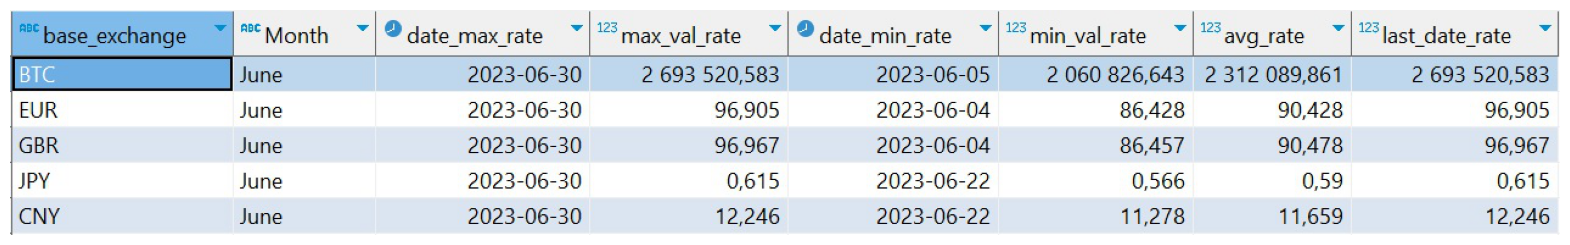

In [65]:
plt.figure(figsize=(20, 40))
plt.axis('off')
image = plt.imread('result_query.jpg')
plt.imshow(image)
plt.show()